In [1]:
graph_folder:str = 'data/pggb_vs_mgc'
edition_file: str = 'temp/yeast_edit'
matrix:str = 'temp/matrix.json'
mash_matrix:str = 'temp/mash.json'

In [2]:
# Colorblind-friendly palette
colors = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 

In [3]:
from seaborn import heatmap, boxplot,stripplot, clustermap, scatterplot, regplot, color_palette
from numpy import triu,array,add,zeros,column_stack, nan
from matplotlib import pyplot as plt
from os import listdir, path
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib import patches as mpatches
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from subprocess import run, PIPE
from scipy.spatial.distance import euclidean
from statistics import mean,median
from pandas import DataFrame,wide_to_long
from pgGraphs import Graph
from math import floor
from os import system, remove, path
from json import load, dump
from tharospytools.matplotlib_tools import get_palette_from_list

Manipulating graph names

In [4]:
all_graphs: list = sorted(listdir(graph_folder))
all_graphs.insert(0, all_graphs.pop())
print(all_graphs)

['15_yeast_pggb_chr_1.gfa', '15_yeast_mgc_CASBIT01_chr_1.gfa', '15_yeast_mgc_CASBIW01_chr_1.gfa', '15_yeast_mgc_CASBIZ01_chr_1.gfa', '15_yeast_mgc_CASBJG01_chr_1.gfa', '15_yeast_mgc_CASBJH01_chr_1.gfa', '15_yeast_mgc_CASBJI01_chr_1.gfa', '15_yeast_mgc_CASBJJ01_chr_1.gfa', '15_yeast_mgc_CASBJL01_chr_1.gfa', '15_yeast_mgc_CASBJM01_chr_1.gfa', '15_yeast_mgc_CASBJN01_chr_1.gfa', '15_yeast_mgc_CASBJQ01_chr_1.gfa', '15_yeast_mgc_CASBJS01_chr_1.gfa', '15_yeast_mgc_CASBJT01_chr_1.gfa', '15_yeast_mgc_CASBJU01_chr_1.gfa', '15_yeast_mgc_CASBJV01_chr_1.gfa']


In [5]:
gfa_graph:Graph = Graph(
    gfa_file=f'{graph_folder}/{all_graphs[0]}'
)

Computing pairwise mash distance

In [6]:
graph_paths:list[str] = sorted(list(gfa_graph.paths.keys()))

In [7]:
if path.exists(mash_matrix):
    mash: list[list[int]] = load(open(mash_matrix,'r',encoding='utf-8'))
else:
    mash:list[list[float]] = [
            [
            0 for _ in range(len(graph_paths))
        ] for _ in range(len(graph_paths))
    ]

    for i,path_name_A in enumerate(graph_paths):
        for j,path_name_B in enumerate(graph_paths):
            mash[i][j]=float(run(['mash', 'dist',f'temp/{path_name_A}.fa',f'temp/{path_name_B}.fa'], stdout=PIPE).stdout.decode('utf-8').split()[2])
    dump(mash,open(mash_matrix,'w',encoding='utf-8'))

In [8]:
for row in mash:
    print("\t".join([str(elt) for elt in row]))

0.0	0.0134036	0.0107836	0.00483188	0.015508	0.0097316	0.0102298	0.00892796	0.0146626	0.00888862	0.00567497	0.0152404	0.0108702	0.00705245	0.00587519
0.0134036	0.0	0.0143537	0.0125875	0.00594242	0.0141502	0.0133059	0.0115761	0.0184352	0.0125405	0.0168391	0.00726808	0.0143537	0.0136991	0.0170111
0.0107836	0.0143537	0.0	0.010441	0.0149234	0.0127767	0.0152404	0.0129677	0.0162193	0.0114865	0.0124	0.0134036	0.00744966	0.0130638	0.0127767
0.00483188	0.0125875	0.010441	0.0	0.0144562	0.0106545	0.0110882	0.00694555	0.015347	0.00652391	0.00617965	0.0143027	0.0103986	0.00748619	0.00766986
0.015508	0.00594242	0.0149234	0.0144562	0.0	0.014871	0.0133059	0.0132087	0.0182524	0.0130157	0.0184352	0.00417861	0.0145076	0.0154542	0.0186813
0.0097316	0.0141502	0.0127767	0.0106545	0.014871	0.0	0.0120298	0.0126347	0.0160531	0.0129677	0.0100207	0.0136496	0.0144049	0.0106545	0.0100623
0.0102298	0.0133059	0.0152404	0.0110882	0.0133059	0.0120298	0.0	0.0112201	0.0146108	0.0120298	0.00846101	0.0144049	0.0149759	0.00

Computing mean and median of mash distance to every other for each sequence

In [9]:
mean_mash:dict = {
    path_name:mean(mash[i]) for i,path_name in enumerate(graph_paths)
}

median_mash:dict = {
    path_name:median(mash[i]) for i,path_name in enumerate(graph_paths)
}

sum_mash:dict = {
    path_name:sum(mash[i]) for i,path_name in enumerate(graph_paths)
}

Computing distances

In [10]:
# First, we compute edition to be sure to have a list of breakpoints
distance_martix:list[list[int]] = [[0 for _ in all_graphs] for _ in all_graphs]

if path.exists(matrix):
    distance_martix: list[list[int]] = load(open(matrix,'r',encoding='utf-8'))
else:
    for i,graph_A in enumerate(all_graphs):
        for j,graph_B in enumerate(all_graphs):
            if i < j:
                # Compute edition
                system(f'pancat edit data/{graph_A} data/{graph_B} -o {edition_file}_{i}_{j}.json')
                # Load edit file in memory
                editions:dict[str,list] = load(open(f"{edition_file}_{i}_{j}.json",'r',encoding='utf-8'))
                # Count editions
                edit_count:int = sum([sum([len(edit_list) for edit_list in edition_classes.values()]) for edition_classes in editions.values()])
                # add count to the two positions
                distance_martix[i][j] = edit_count
                distance_martix[j][i] = edit_count
                # delete temp file
                #remove(edition_file)
                
    dump(distance_martix,open(matrix,'w',encoding='utf-8'))

In [11]:
for row in distance_martix:
    print("\t".join([str(elt) for elt in row]))

0	86475	93432	98735	87932	88006	94277	71602	81715	79158	93530	82455	99186	94491	84409	80148
86475	0	86245	95466	83017	87559	62010	84791	69912	70809	72317	56196	90341	85764	56372	61157
93432	86245	0	96263	60690	60686	95089	84096	50705	70568	64464	90255	86404	95149	83577	71966
98735	95466	96263	0	80927	92715	100696	96325	86190	94625	85413	86442	72289	72124	83808	96607
87932	83017	60690	80927	0	59140	97497	76078	40973	67572	53688	85547	80722	85837	80121	64636
88006	87559	60686	92715	59140	0	95053	76476	57937	64056	66350	88019	76646	94033	84043	63526
94277	62010	95089	100696	97497	95053	0	74481	84904	79557	88337	70768	105427	100520	68786	77593
71602	84791	84096	96325	76078	76476	74481	0	72409	73164	84992	77489	101984	99951	67627	72660
81715	69912	50705	86190	40973	57937	84904	72409	0	56363	41185	72542	78677	79824	64808	51791
79158	70809	70568	94625	67572	64056	79557	73164	56363	0	62240	71859	85658	87137	73067	31842
93530	72317	64464	85413	53688	66350	88337	84992	41185	62240	0	69679	72038	7

/home/sidubois/miniconda3/envs/dev/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/sidubois/miniconda3/envs/dev/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


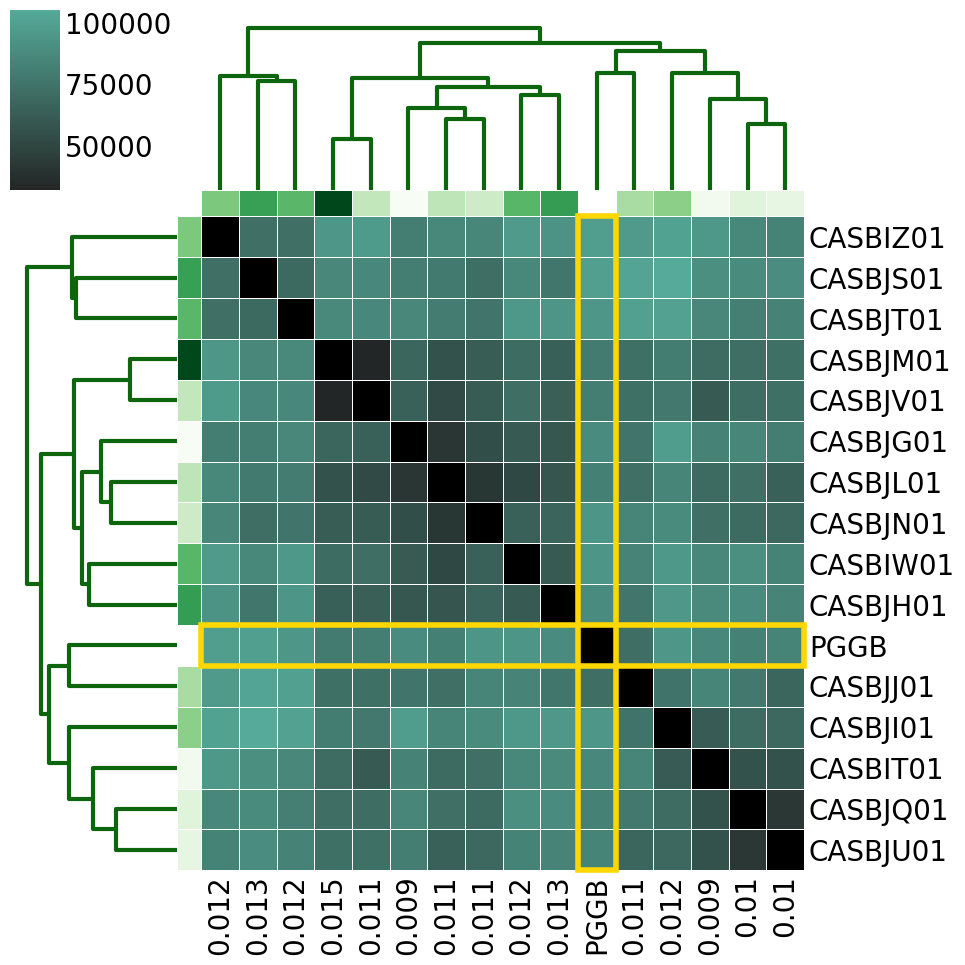

In [12]:
# Setting font parameters
plt.rcParams.update({'font.size': 20})

# We define labels list
labels:list[str] = ['PGGB' if 'pggb' in label else label.split('_')[3] for label in all_graphs]
# Defining colors
green_pal = color_palette("dark:#5A9", as_cmap=True)
green_pal.set_bad("black")
colors = ['white'] + get_palette_from_list([sum_mash[x] for x in graph_paths],cmap_name='Greens')
# Transforming into pandas
df:DataFrame = DataFrame(distance_martix)
# Plotting the fig
fig = clustermap(
    df,
    linewidth=0.5,
    mask=(df==0),
    annot=False,
    tree_kws=dict(linewidths=3, colors=(0.05, 0.4, 0.05)),
    xticklabels=['PGGB']+[round(mean_mash[x],3) for x in graph_paths],
    yticklabels=labels,
    cmap=green_pal,
    col_colors=colors,
    row_colors=colors,
)
fig.tick_params(length=0)
fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.get_yticklabels(), rotation=0)

# We add a square to highlight a specific graph
reordered_labels:list[int] = df.index[fig.dendrogram_row.reordered_ind].tolist()
# PGGB is at location 0
pggb_pos:int = reordered_labels.index(0)
# We then add the patch to highlight the PGGB graph
x, y, w, h = 0, pggb_pos, len(reordered_labels), 1
for _ in range(2):
    fig.ax_heatmap.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='gold', lw=4, clip_on=False))
    x, y = y, x # exchange the roles of x and y
    w, h = h, w # exchange the roles of w and h

plt.show()


In [13]:
matrix:str = 'temp/matrix_ref.json'
graph_folder:str = 'data/mgc_vs_mgc'

In [14]:
all_graphs: list = sorted(listdir(graph_folder))
all_graphs.insert(0, all_graphs.pop())
print(all_graphs)

['15_yeast_rotate_CASBJU01_3.gfa', '15_yeast_rotate_CASBJG01_1.gfa', '15_yeast_rotate_CASBJG01_2.gfa', '15_yeast_rotate_CASBJG01_3.gfa', '15_yeast_rotate_CASBJT01_1.gfa', '15_yeast_rotate_CASBJT01_2.gfa', '15_yeast_rotate_CASBJT01_3.gfa', '15_yeast_rotate_CASBJU01_1.gfa', '15_yeast_rotate_CASBJU01_2.gfa']


In [15]:
# First, we compute edition to be sure to have a list of breakpoints
distance_martix:list[list[int]] = [[0 for _ in all_graphs] for _ in all_graphs]

if path.exists(matrix):
    distance_martix: list[list[int]] = load(open(matrix,'r',encoding='utf-8'))
else:
    for i,graph_A in enumerate(all_graphs):
        for j,graph_B in enumerate(all_graphs):
            if i < j:
                # Compute edition
                system(f'pancat edit data/{graph_A} data/{graph_B} -o {edition_file}_{i}_{j}.json')
                # Load edit file in memory
                editions:dict[str,list] = load(open(f"{edition_file}_{i}_{j}.json",'r',encoding='utf-8'))
                # Count editions
                edit_count:int = sum([sum([len(edit_list) for edit_list in edition_classes.values()]) for edition_classes in editions.values()])
                # add count to the two positions
                distance_martix[i][j] = edit_count
                distance_martix[j][i] = edit_count
                # delete temp file
                #remove(edition_file)
                
    dump(distance_martix,open(matrix,'w',encoding='utf-8'))

In [16]:
for row in distance_martix:
    print("\t".join([str(elt) for elt in row]))

0	10795	8528	81980	74195	78102	62844	69933	63904
10795	0	4541	74569	81054	84639	70723	66174	72239
8528	4541	0	75110	80269	82998	69800	64081	70996
81980	74569	75110	0	15787	13318	79794	75621	82000
74195	81054	80269	15787	0	12203	72779	80080	74833
78102	84639	82998	13318	12203	0	76898	82809	78280
62844	70723	69800	79794	72779	76898	0	11623	5582
69933	66174	64081	75621	80080	82809	11623	0	7759
63904	72239	70996	82000	74833	78280	5582	7759	0


/home/sidubois/miniconda3/envs/dev/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/sidubois/miniconda3/envs/dev/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


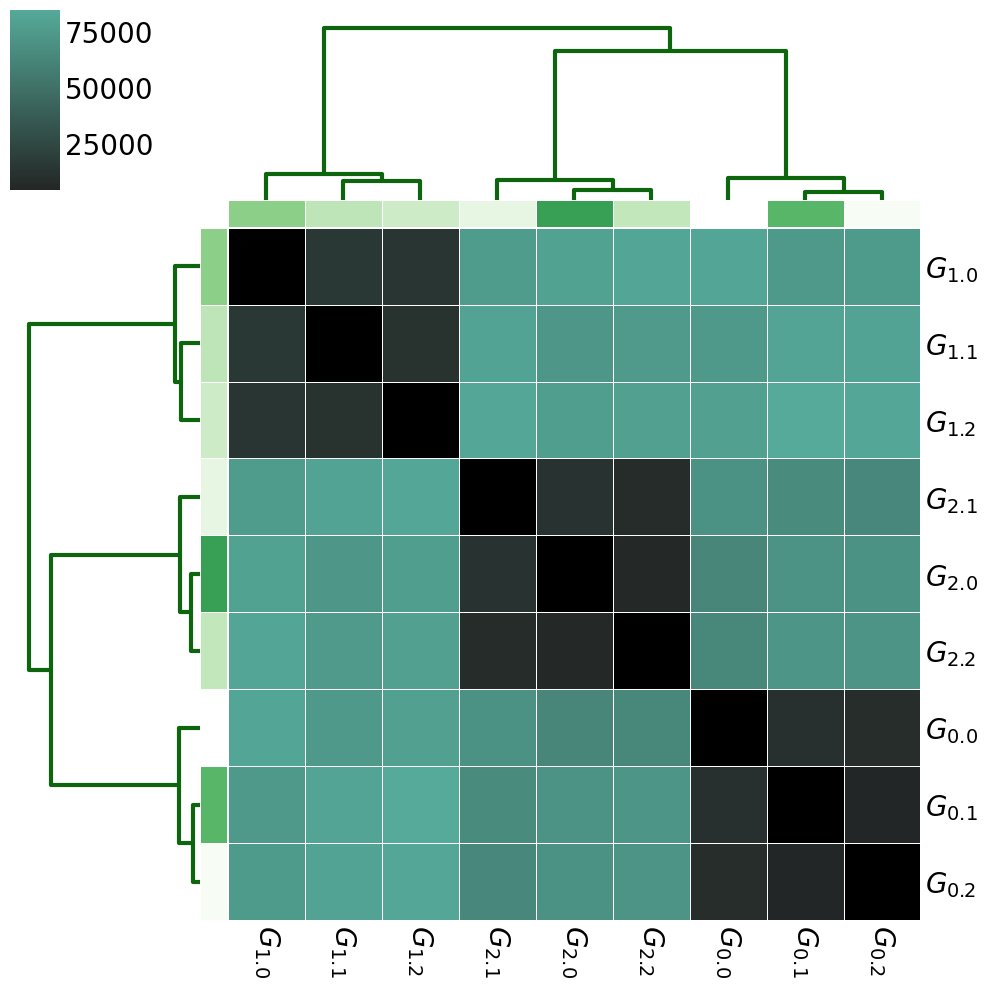

In [24]:
# Setting font parameters
plt.rcParams.update({'font.size': 20})

# We define labels list
labels:list[str] = ['$G_{'+str(i//3)+'.'+str(i%3)+'}$' for i in range(len(all_graphs))]
# Defining colors
green_pal = color_palette("dark:#5A9", as_cmap=True)
green_pal.set_bad("black")
colors = ['white'] + get_palette_from_list([sum_mash[x] for x in graph_paths],cmap_name='Greens')
# Transforming into pandas
df:DataFrame = DataFrame(distance_martix)
# Plotting the fig
fig = clustermap(
    df,
    linewidth=0.5,
    mask=(df==0),
    annot=False,
    tree_kws=dict(linewidths=3, colors=(0.05, 0.4, 0.05)),
    xticklabels=labels,
    yticklabels=labels,
    cmap=green_pal,
    col_colors=colors,
    row_colors=colors,
)
fig.tick_params(length=0)
fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.get_yticklabels(), rotation=0)
fig.ax_heatmap.set_xticklabels(fig.ax_heatmap.get_yticklabels(), rotation=-90)

plt.show()